Welcome to Voxelmap!

The first thing we'll do is train the neural network (Network A). We'll then test the network to see how it performs.

# Imports

In [30]:
# imports
import time
import os
import numpy as np
from matplotlib import pyplot as plt
from utilities import network_a, losses
import torch
from torch.utils.data import Dataset
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

# File Names

In [56]:
import os

Patient_number = "P1"
NoScatter = True
Scatter = False
DatasetType="SPARE"
DayofTreatment = 1
NetworkType="A"

if NoScatter == Scatter:
    raise ValueError("Set exactly one of NoScatter or Scatter to True.")

scatter_tag = "NS" if NoScatter else "SC"

im_dir = os.path.join(
    "/srv/shared/SPARE", # Will Change Based on Your Folder
    f"MC_V_{Patient_number}_{scatter_tag}_{DayofTreatment:02d}"
)

expt_description = f"Network_A_{DatasetType}_{Patient_number}"
filename = f"Train_A_SPARE_{DatasetType}_{Patient_number}"

print("im_dir =", im_dir)


im_dir = /srv/shared/SPARE/MC_V_P1_NS_01


# Setup Dataset

In [45]:
# set up training dataset class
class SupervisedDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None):
        self.im_dir = im_dir
        self.im_size = im_size

    def __len__(self):
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])

    def __getitem__(self, idx):
        # Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])
        target_file = proj_list[idx]
        proj_name = os.path.join(self.im_dir, format(target_file))
        target_proj = np.load(proj_name)
        target_proj = (target_proj - np.min(target_proj)) / (np.max(target_proj) - np.min(target_proj))

        # Find target DVF
        vol_num = target_file[:2]
        dvf_name = os.path.join(self.im_dir, format('DVF_' + vol_num + '_mha.npy'))
        target_dvf = np.load(dvf_name)

        # Find source projection
        source_file = '06_' + target_file[3:]
        proj_name = os.path.join(self.im_dir, format(source_file))
        source_proj = np.load(proj_name)
        source_proj = (source_proj - np.min(source_proj)) / (np.max(source_proj) - np.min(source_proj))

        # Find source volume
        vol_name = os.path.join(self.im_dir, format('subCT_06_mha.npy'))
        source_vol = np.load(vol_name)
        source_vol = (source_vol - np.min(source_vol)) / (np.max(source_vol) - np.min(source_vol))

        # Find source abdomen
        vol_name = os.path.join(self.im_dir, format('sub_Abdomen_mha.npy'))
        source_hull = np.load(vol_name)

        # Reshape data
        source_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        source_projections[0, :, :] = np.asarray(source_proj)
        target_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        target_projections[0, :, :] = np.asarray(target_proj)

        source_volumes = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_volumes[0, :, :, :] = np.asarray(source_vol)
        source_abdomen = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_abdomen[0, :, :, :] = np.asarray(source_hull)

        target_flow = np.zeros((3, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        target_flow[0, :, :, :] = target_dvf[:, :, :, 0]
        target_flow[1, :, :, :] = target_dvf[:, :, :, 1]
        target_flow[2, :, :, :] = target_dvf[:, :, :, 2]

        data = {'source_projections': torch.from_numpy(source_projections),
                'target_projections': torch.from_numpy(target_projections),
                'source_volumes': torch.from_numpy(source_volumes),
                'source_abdomen': torch.from_numpy(source_abdomen),
                'target_flow': torch.from_numpy(target_flow)}

        return data

Lookin' good! Now we will create training and validation datasets

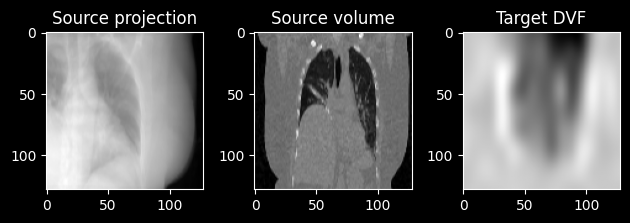

In [47]:
# Generate test loader
batch_size = 1
im_size = 128
exampleset = SupervisedDataset(im_dir=im_dir, im_size=im_size)
exampleloader = torch.utils.data.DataLoader(exampleset, batch_size=batch_size)
data = next(iter(exampleloader))

source_proj, target_proj, source_vol, source_abdomen, target_flow = data['source_projections'], \
                                                                                        data['target_projections'], \
                                                                                        data['source_volumes'], \
                                                                                        data['source_abdomen'], \
                                                                                        data['target_flow']
# visualise projection, volume and DVF
f = plt.figure()
plt.subplot(1,3,1)
source_proj = np.squeeze(source_proj)
plt.imshow(source_proj, cmap='gray')
plt.title('Source projection')

plt.subplot(1,3,2)
source_vol = np.squeeze(source_vol)
plt.imshow(np.transpose(source_vol[:,:, int(source_vol.shape[2] / 2)]), cmap='gray')
plt.title('Source volume')

plt.subplot(1,3,3)
target_flow = np.squeeze(target_flow)
plt.imshow(np.flipud(np.transpose(target_flow[1,:,:, int(source_vol.shape[2] / 2)])), cmap='gray')
plt.title('Target DVF')

f.tight_layout()
plt.show()

Network time! Let's set up a cuda implementation of the network, a loss function (good ol' MSE will do! but we're computing it within a thoracoabdominal mask) and an optimizer

In [48]:
import numpy as np

def get_numpy_similarity(path1, path2):
    # 1. Load the numpy arrays
    arr1 = np.load(path1)
    arr2 = np.load(path2)

    # 2. Flatten the arrays to 1D vectors
    # This works regardless of shape (e.g., 128x128x128 or 3x128x128x128)
    vec1 = arr1.flatten()
    vec2 = arr2.flatten()

    # 3. Calculate Dot Product
    dot_product = np.dot(vec1, vec2)

    # 4. Calculate Norms (Magnitudes)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    # 5. Compute Cosine Similarity
    # We add a tiny epsilon (1e-9) to avoid division by zero
    similarity = dot_product / (norm1 * norm2 + 1e-9)

    return similarity

# Usage
file_a = im_dir + "/06_Proj_00064_bin.npy"
file_b = "/srv/shared/SPARE/MC_V_P1_SC_02/"+ "source/06_Proj_00064_bin.npy"
score = get_numpy_similarity(file_a, file_b)
print(f"Cosine Similarity: {score:.6f}")

Cosine Similarity: 0.998334


It's important to note that , this difference is because there could have been changes to the anatomy between planning and treatment day.

Are you ready? Next thing to do is to train the network :) We'll save the weights and a plot of the loss curves. We recommend training for 50 epochs. (Using a NVIDIA RTX A6000, this will take 6-8 hours, so we may need to come back tomorrow.)

Let's instantiate the validation dataset class, set up a cuda implementation, and load the pre-trained weights of our network. We'll also print the number of trainable parameters for our records.

# Training

In [49]:
# generate train/test split
im_size = 128
batch_size = 8
dataset = SupervisedDataset(im_dir=im_dir, im_size=im_size)
split = [int(len(dataset) * 0.9), int(len(dataset) * 0.1)]
trainset, valset = torch.utils.data.dataset.random_split(dataset, split)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

In [61]:
# set up network
model = network_a.model(im_size, int_steps=10)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

# set loss function and optimizer
flow_mask = losses.flow_mask()
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)

In [93]:
# =========================
# TRAIN (supports resume)
# =========================

import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

from continue_training import (
    save_checkpoint,
    load_checkpoint_if_available,
    plot_losses,
)

# ---- device (pick one and keep it consistent) ----
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ---- set up network (EXACTLY as before) ----
model = network_a.model(im_size, int_steps=10).to(device)

# ---- loss + optimizer ----
flow_mask = losses.flow_mask()
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)

print('Training (on ' + str(device) + ')...')
tic = time.time()

# IMPORTANT:
# epoch_num is the TOTAL epoch you want to reach.
# If you trained to 50 and want to continue to 100, set epoch_num = 100.
epoch_num = 4

save_dir = f"{DatasetType}_{NetworkType}_{Patient_number}_weights"
plot_dir = f"{DatasetType}_{NetworkType}_{Patient_number}_plots"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)
# ---- resume (loads model+optimizer+history if checkpoint exists) ----
ckpt_path = os.path.join(save_dir, f"{DatasetType}_{NetworkType}_{Patient_number}_ckpt.pth")
start_epoch, min_val_loss, train_losses, val_losses = load_checkpoint_if_available(
    ckpt_path=ckpt_path,
    model=model,
    optimizer=optimizer,
    device=device,
)

print(f"Starting at epoch {start_epoch} (target total: {epoch_num})")

# ---- training loop ----
for epoch in range(start_epoch, epoch_num + 1):
    model.train()
    train_loss = 0.0

    for data in trainloader:
        source_proj = data['source_projections'].to(device)
        target_proj = data['target_projections'].to(device)
        source_vol = data['source_volumes'].to(device)
        source_abdomen = data['source_abdomen'].to(device)
        target_flow = data['target_flow'].to(device)

        optimizer.zero_grad(set_to_none=True)
        _, predict_flow = model.forward(source_proj, target_proj, source_vol)
        loss = flow_mask.loss(target_flow, predict_flow, source_abdomen)

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for valdata in valloader:
            source_proj = valdata['source_projections'].to(device)
            target_proj = valdata['target_projections'].to(device)
            source_vol = valdata['source_volumes'].to(device)
            source_abdomen = valdata['source_abdomen'].to(device)
            target_flow = valdata['target_flow'].to(device)

            _, predict_flow = model.forward(source_proj, target_proj, source_vol)
            loss = flow_mask.loss(target_flow, predict_flow, source_abdomen)
            val_loss += loss.item()

    # ---- metrics ----
    toc = time.time()
    time_elapsed = (toc - tic) / 3600
    hours = int(np.floor(time_elapsed))
    minutes = int((time_elapsed - hours) * 60)

    train_avg = train_loss / len(trainloader)
    val_avg = val_loss / len(valloader)

    print('Epoch: %d | train loss: %.4f | val loss: %.4f | total time: %d hours %d minutes' %
          (epoch, train_avg, val_avg, hours, minutes))

    train_losses.append(train_avg)
    val_losses.append(val_avg)

    # ---- save best weights (inference) ----
    best_path = os.path.join(save_dir, f"{DatasetType}_{NetworkType}_{Patient_number}_best.pth")
    if val_avg < min_val_loss:
        min_val_loss = val_avg
        torch.save(model.state_dict(), best_path)

    # ---- save resume checkpoint (continue training) ----
    save_checkpoint(
        ckpt_path=ckpt_path,
        model=model,
        optimizer=optimizer,
        epoch=epoch,            # last completed epoch
        best_val=min_val_loss,
        train_losses=train_losses,
        val_losses=val_losses,
    )

    # ---- plot ----
    plot_losses(
        plot_dir=plot_dir,
        filename=filename,
        expt_description=expt_description,
        train_losses=train_losses,
        val_losses=val_losses,
        hours=hours,
        minutes=minutes,
    )

print('Finished training')
torch.cuda.empty_cache()

# Show final plot
final_plot = os.path.join(plot_dir,f"{DatasetType}_{NetworkType}_{Patient_number}_TRAINvsVAL.png")
if os.path.exists(final_plot):
    plt.imshow(plt.imread(final_plot))
    plt.axis("off")
    plt.show()

Training (on cuda:0)...
Starting at epoch 4 (target total: 4)
Epoch: 4 | train loss: 0.8297 | val loss: 0.7037 | total time: 0 hours 19 minutes
Finished training


# Testing

## Setting File Names

In [94]:
# file names
import os

Patient_number = "P1"
NoScatter = False
Scatter = True
DatasetType="SPARE"
DayofTreatment = 2
NetworkType="A"

if NoScatter == Scatter:
    raise ValueError("Set exactly one of NoScatter or Scatter to True.")

scatter_tag = "NS" if NoScatter else "SC"

im_dir = os.path.join(
    "/srv/shared/SPARE", # Will Change Based on Your Folder
    f"MC_V_{Patient_number}_{scatter_tag}_{DayofTreatment:02d}"
)


expt_file = f'{DatasetType}_{NetworkType}_{Patient_number}'
test_file =  os.path.join(
    "/srv/shared/SPARE", # Will Change Based on Your Folder
    f"MC_V_{Patient_number}_{scatter_tag}_{DayofTreatment:02d}"
) # We are using the treatment day dataset with scatter

Saved_folder="/home/abhishek/PycharmProjects/Voxelmap/" # Change According to Your Folder
target_itv_ptv_dir = f"{Saved_folder}Target_ITVs_ALL_{DatasetType}_{NetworkType}_{Patient_number}" # PLEASE CHANGE TO YOUR DIR
print(test_file)
print(target_itv_ptv_dir)


/srv/shared/SPARE/MC_V_P1_SC_02
/home/abhishek/PycharmProjects/Voxelmap/Target_ITVs_ALL_SPARE_A_P1


## Obtaining  Target PTV for All 680 Projections

In [95]:
import os
import numpy as np
import torch
from utilities import spatialTransform


def _ensure_src_ptv_5d(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 3:
        x = x[None, None, ...]
    elif x.ndim == 5:
        pass
    else:
        raise ValueError(f"Unsupported source PTV shape {x.shape}")
    return x.astype(np.float32)


def _ensure_dvf_5d(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 4 and x.shape[-1] == 3:
        x = np.transpose(x, (3, 0, 1, 2))[None, ...]
    elif x.ndim == 4 and x.shape[0] == 3:
        x = x[None, ...]
    elif x.ndim == 5 and x.shape[1] == 3:
        pass
    else:
        raise ValueError(f"Unsupported DVF shape {x.shape}")
    return x.astype(np.float32)


def generate_target_itv_ptv_10bins(
    im_dir: str,
    out_dir: str,
    im_size: int = 128,
    dvf_folder: str | None = None,
    source_ptv_relpath: str = os.path.join("source", "itv_PTV_mha.npy"),
    #source_ptv_relpath: str = os.path.join("sub_PTV_mha.npy"),
    dvf_pattern: str = "DVF_{:02d}_mha.npy",
    out_pattern: str = "Target_ITV_PTV_{:02d}_mha.npy",
):
    """
    Saves Target ITV PTVs into out_dir.
    """
    if dvf_folder is None:
        dvf_folder = im_dir

    os.makedirs(out_dir, exist_ok=True)

    src_ptv_path = os.path.join(im_dir, source_ptv_relpath)
    if not os.path.exists(src_ptv_path):
        raise FileNotFoundError(f"Missing source ITV PTV: {src_ptv_path}")

    source_ptv_np = _ensure_src_ptv_5d(np.load(src_ptv_path))
    if source_ptv_np.shape[-3:] != (im_size, im_size, im_size):
        raise ValueError(f"Source PTV spatial shape {source_ptv_np.shape[-3:]} != {(im_size,)*3}")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    transformer = spatialTransform.Network([im_size, im_size, im_size]).to(device).eval()

    source_ptv_t = torch.from_numpy(source_ptv_np).to(device)

    for b in range(1, 11):
        dvf_path = os.path.join(dvf_folder, dvf_pattern.format(b))
        if not os.path.exists(dvf_path):
            raise FileNotFoundError(f"Missing DVF file: {dvf_path}")

        dvf_np = _ensure_dvf_5d(np.load(dvf_path))
        if dvf_np.shape[-3:] != (im_size, im_size, im_size):
            raise ValueError(f"DVF spatial shape mismatch for {dvf_path}")

        dvf_t = torch.from_numpy(dvf_np).to(device)

        with torch.no_grad():
            tgt_ptv_t = transformer(source_ptv_t, dvf_t)

        tgt_ptv_np = tgt_ptv_t.detach().cpu().numpy()  # [1,1,D,H,W]

        out_path = os.path.join(out_dir, out_pattern.format(b))
        np.save(out_path, tgt_ptv_np)
        print(f"Saved {out_path}")

    print("Done. Target ITV PTVs saved.")


# -------------------------
# Example usage
# -------------------------

# Save into MC_V_P1_SC_02/Target_ITV/
generate_target_itv_ptv_10bins(
    im_dir=test_file,
    out_dir=f"{Saved_folder}Target_ITV_{DatasetType}_{NetworkType}_{Patient_number}",
    im_size=128,
)


Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P1/Target_ITV_PTV_01_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P1/Target_ITV_PTV_02_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P1/Target_ITV_PTV_03_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P1/Target_ITV_PTV_04_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P1/Target_ITV_PTV_05_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P1/Target_ITV_PTV_06_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P1/Target_ITV_PTV_07_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P1/Target_ITV_PTV_08_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P1/Target_ITV_PTV_09_mha.npy
Saved /home/abhishek/PycharmProjects/Voxelmap/Target_ITV_SPARE_A_P1/Target_ITV_PTV_10_mha.npy
Done. Target ITV PTVs saved.


In [96]:
import os
import shutil
import csv

# -----------------------------
# Paths
# -----------------------------
target_itv_dir = f"{Saved_folder}Target_ITV_{DatasetType}_{NetworkType}_{Patient_number}"
respbin_csv = f"{test_file}/RespBin.csv"
output_dir = f"{Saved_folder}Target_ITVs_ALL_{DatasetType}_{NetworkType}_{Patient_number}"

os.makedirs(output_dir, exist_ok=True)

targets_created = 0

# -----------------------------
# Read CSV and create ITVs
# -----------------------------
with open(respbin_csv, newline='') as csvfile:
    reader = csv.reader(csvfile)

    for target_idx, row in enumerate(reader, start=1):

        # Skip empty rows
        if not row:
            continue

        # Single column = breathing phase
        breathing_phase = int(row[0])
        if not (1 <= breathing_phase <= 10):
            raise ValueError(
                f"Invalid breathing phase {breathing_phase} at target {target_idx}"
            )

        phase_str = f"{breathing_phase:02d}"

        src_itv = os.path.join(
            target_itv_dir,
            f"Target_ITV_PTV_{phase_str}_mha.npy"
        )

        if not os.path.exists(src_itv):
            raise FileNotFoundError(f"Missing ITV file: {src_itv}")

        dst_itv = os.path.join(
            output_dir,
            f"Target_{target_idx:05d}_ITV_PTV.npy"
        )

        shutil.copy(src_itv, dst_itv)
        targets_created += 1

        if targets_created % 50 == 0:
            print(f"Processed {targets_created} targets...")

print(f"\n Successfully created {targets_created} Target ITV PTVs")
print(f" Output directory: {output_dir}")


Processed 50 targets...
Processed 100 targets...
Processed 150 targets...
Processed 200 targets...
Processed 250 targets...
Processed 300 targets...
Processed 350 targets...
Processed 400 targets...
Processed 450 targets...
Processed 500 targets...
Processed 550 targets...
Processed 600 targets...
Processed 650 targets...

 Successfully created 680 Target ITV PTVs
 Output directory: /home/abhishek/PycharmProjects/Voxelmap/Target_ITVs_ALL_SPARE_A_P1


## Preparing testing Functions

In [97]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class validateSPAREDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None):
        self.im_dir = im_dir
        # Source files (Phase 06) and global contours are in the 'source' subfolder Within the Treatment Day Dataset
        self.ref_dir = os.path.join(im_dir, 'source')
        self.im_size = im_size

    def __len__(self):
        # Count target projections (excluding phase 06 reference files)
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy') and not n.startswith('06_')])

    def __getitem__(self, idx):
        # 1. Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy') and not n.startswith('06_')])
        target_file = proj_list[idx]
        target_proj = np.load(os.path.join(self.im_dir, target_file))

        # 2. Find target volume using RespBin.csv logic
        resp_bin_path = os.path.join(self.im_dir, 'RespBin.csv')
        resp_bins = np.genfromtxt(resp_bin_path)
        bin_val = int(resp_bins[idx])

        # Format the volume number (e.g., 1 -> '01', 10 -> '10')
        if bin_val < 10:
            vol_num = '0' + str(bin_val)
        else:
            vol_num = str(bin_val) # Assuming 10 is the max, else use str(bin_val)

        # Load the volume corresponding to the bin index
        target_vol = np.load(os.path.join(self.im_dir, f'subCT_{vol_num}_mha.npy'))

        # 3. Find source data (Reference Phase 06) from the 'source' folder
        # Reconstructs source filename (e.g., 01_Proj_001.npy -> 06_Proj_001.npy)
        source_proj_name = '06_'+"Proj_" + '_'.join(target_file.split('_')[1:])
        source_proj = np.load(os.path.join(self.ref_dir, source_proj_name))

        source_vol = np.load(os.path.join(self.im_dir, 'subCT_06_mha.npy'))

        # 4. Find restricted contours (Lung and PTV only) from 'source' folder
        source_lung = np.load(os.path.join(self.ref_dir, 'itv_Lung_mha.npy'))
        source_ptv = np.load(os.path.join(self.ref_dir, 'itv_PTV_mha.npy'))

        # 5. Load Angle
        angle_data = np.genfromtxt(os.path.join(self.im_dir, 'Angles.csv'))
        angle = angle_data[idx]

        # Find target contours
        target_num = target_file.split('_')
        target_num = target_num[1]


        vol_name = os.path.join(target_itv_ptv_dir, format('Target_' + target_num + '_ITV_PTV.npy'))
        target_ptv = np.load(vol_name)

        # 6. Reshape and convert to Tensors
        def to_tensor(data, is_vol=True):
            if is_vol:
                out = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
                out[0, ...] = np.asarray(data)
            else:
                out = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
                out[0, ...] = np.asarray(data)
            return torch.from_numpy(out)

        data = {
            'source_projections': to_tensor(source_proj, is_vol=False),
            'target_projections': to_tensor(target_proj, is_vol=False),
            'source_volumes': to_tensor(source_vol),
            'source_lung': to_tensor(source_lung),
            'source_ptv': to_tensor(source_ptv),
            'target_volumes': to_tensor(target_vol),
            'angle': angle,
            'target_ptv' :to_tensor(target_ptv)
        }

        return data

## Initiating Testing

In [98]:
# Generate test loader
batch_size = 1
im_size = 128
#dataset = validateSPAREDataset(im_dir=test_file, ref_dir=test_file + '/source', im_size=im_size)
# The class now handles the '/source' path internally
dataset = validateSPAREDataset(im_dir=test_file, im_size=im_size)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Import network and set up cuda implementation
#model = network_a.VxmDense(im_size, int_steps=10)
model = network_a.model(im_size, int_steps=10)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load weights
PATH = f'{DatasetType}_{NetworkType}_{Patient_number}_weights/' +f"{DatasetType}_{NetworkType}_{Patient_number}_best" + '.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

print('Number of paramters: %d' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))

Number of paramters: 10836973


In [99]:
# Load transformer
from utilities import spatialTransform
transformer = spatialTransform.Network([im_size, im_size, im_size])
transformer.to(device)

Network(
  (transformer): SpatialTransformer()
)

In [100]:
# loss functions
centroid_ptv = losses.centroid_ptv()
dice = losses.dice()
jacobian_determinant = losses.jacobian_determinant()
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Initialise Target (PTV) tracking metrics
# These remain the same as they track the 3D offset in mm
tar_lr, tar_si, tar_ap = [], [], [] # Ground-truth (if available)
pred_lr, pred_si, pred_ap = [], [], [] # Predicted tracking
test_angles = []

# Initialise Geometry/Regularity metrics
test_dice = []
test_detJ = []  # Jacobian determinant for flow regularity

# Updated OAR tracking metrics (Lung only now)
# Since you are using itv_Lung_mha.npy, we use a single lung metric list
lung_dice = []

# Initialise Image Quality metrics
# These track how well the warped source_vol matches target_vol
test_mse, test_ssim, test_psnr = [], [], []



In [101]:
print('Testing...')
for i, data in enumerate(testloader, 0):
    # Unpack only what is provided by the new validateSPAREDataset
    source_proj = data['source_projections'].to(device)
    target_proj = data['target_projections'].to(device)
    source_vol  = data['source_volumes'].to(device)
    source_lung = data['source_lung'].to(device) # itv_Lung_mha.npy
    source_ptv  = data['source_ptv'].to(device)  # itv_PTV_mha.npy
    target_vol  = data['target_volumes'].to(device)
    angle       = data['angle'].to(device)
    target_ptv = data['target_ptv'].to(device)


    # 1. Forward pass: Predict PTV deformation and Flow Field
    # Note: predict_ptv is the source_ptv warped by the predicted flow
    #predict_ptv, predict_flow = model.forward(source_proj, target_proj, source_ptv)

    _, predict_flow = model.forward(source_proj, target_proj, source_ptv)

    predict_ptv = transformer.forward(source_ptv, predict_flow)
    # target_ptv = transformer.forward(source_ptv, target_flow)

    # 2. Centroid tracking for predicted PTV
    lr, si, ap = centroid_ptv.loss(target_ptv)
    # convert to mm
    lr = (4 * 450 / 512) * lr
    si = (2 * 220 / 256) * si
    ap = (4 * 450 / 512) * ap

    tar_lr.append(lr)
    tar_si.append(si)
    tar_ap.append(ap)

    lr, si, ap = centroid_ptv.loss(predict_ptv)
    # convert to mm
    lr = (4 * 450 / 512) * lr
    si = (2 * 220 / 256) * si
    ap = (4 * 450 / 512) * ap

    pred_lr.append(lr)
    pred_si.append(si)
    pred_ap.append(ap)


      # compute and save dice similarity
    dice_sim = dice.loss(target_ptv, predict_ptv)
    test_dice.append(dice_sim.item())

    # 3. Compute and save Jacobian violation ratio (Regularity check)
    disp = np.zeros((im_size, im_size, im_size, 3), dtype=np.float32)
    metric_flows = np.squeeze(predict_flow.detach().cpu().numpy())
    disp[:, :, :, 0] = metric_flows[0, :, :, :]
    disp[:, :, :, 1] = metric_flows[1, :, :, :]
    disp[:, :, :, 2] = metric_flows[2, :, :, :]

    detJ = jacobian_determinant.loss(disp)
    detJ_ratio = sum(j <= 0 for j in detJ.flatten()) / detJ.size
    test_detJ.append(detJ_ratio)

    # 4. Save gantry angle
    test_angles.append(angle.item())

    # 5. Warp volumes and calculate Image Quality metrics
    predict_vol = transformer.forward(source_vol, predict_flow)

    # Detach and flatten for numpy-based metrics
    metric_input = target_vol.cpu().detach().numpy().flatten()
    metric_pred = predict_vol.cpu().detach().numpy().flatten()

    # Calculate MSE, SSIM, and PSNR
    mse_val = np.sqrt(np.mean(np.square((metric_input - metric_pred))))
    ssim_val = ssim(metric_input, metric_pred, data_range=np.max(metric_pred) - np.min(metric_pred))
    psnr_val = psnr(metric_input, metric_pred)

    test_mse.append(mse_val)
    test_ssim.append(ssim_val)
    test_psnr.append(psnr_val)

    # 6. Warp Lung for visualization or future evaluation
    predict_lung = transformer.forward(source_lung, predict_flow)

    if i % 10 == 0:
        print(f"{i} of {len(testloader)}")

Testing...
0 of 680
10 of 680
20 of 680
30 of 680
40 of 680
50 of 680
60 of 680
70 of 680
80 of 680
90 of 680
100 of 680
110 of 680
120 of 680
130 of 680
140 of 680
150 of 680
160 of 680
170 of 680
180 of 680
190 of 680
200 of 680
210 of 680
220 of 680
230 of 680
240 of 680
250 of 680
260 of 680
270 of 680
280 of 680
290 of 680
300 of 680
310 of 680
320 of 680
330 of 680
340 of 680
350 of 680
360 of 680
370 of 680
380 of 680
390 of 680
400 of 680
410 of 680
420 of 680
430 of 680
440 of 680
450 of 680
460 of 680
470 of 680
480 of 680
490 of 680
500 of 680
510 of 680
520 of 680
530 of 680
540 of 680
550 of 680
560 of 680
570 of 680
580 of 680
590 of 680
600 of 680
610 of 680
620 of 680
630 of 680
640 of 680
650 of 680
660 of 680
670 of 680


## Saving Test Results

In [103]:
import os
import numpy as np

# Output directory


out_dir = f"{plot_dir}/{expt_file}_Experiment"
os.makedirs(out_dir, exist_ok=True)


# Ensure everything is numpy before saving

def as_numpy(x):
    if isinstance(x, np.ndarray):
        return x
    if isinstance(x, (list, tuple)):
        out = []
        for v in x:
            if hasattr(v, "detach"):  # torch tensor
                out.append(float(v.detach().cpu().item()) if v.numel() == 1 else v.detach().cpu().numpy())
            else:
                out.append(v)
        return np.asarray(out)
    if hasattr(x, "detach"):  # torch tensor
        return x.detach().cpu().numpy()
    return np.asarray(x)

# 1) Target tracking metrics

np.save(os.path.join(out_dir, "test_angles.npy"), as_numpy(test_angles))
np.save(os.path.join(out_dir, "tar_lr_mm.npy"),  as_numpy(tar_lr))
np.save(os.path.join(out_dir, "tar_si_mm.npy"),  as_numpy(tar_si))
np.save(os.path.join(out_dir, "tar_ap_mm.npy"),  as_numpy(tar_ap))
np.save(os.path.join(out_dir, "pred_lr_mm.npy"), as_numpy(pred_lr))
np.save(os.path.join(out_dir, "pred_si_mm.npy"), as_numpy(pred_si))
np.save(os.path.join(out_dir, "pred_ap_mm.npy"), as_numpy(pred_ap))
np.save(os.path.join(out_dir, "test_dice.npy"),  as_numpy(test_dice))   # PTV Dice
np.save(os.path.join(out_dir, "test_detJ.npy"),  as_numpy(test_detJ))   # Jacobian violations


# 2) OAR metrics (optional)

# np.save(os.path.join(out_dir, "lung_itv_dice.npy"), as_numpy(lung_dice))


# 3) Image quality metrics

np.save(os.path.join(out_dir, "test_mse.npy"),  as_numpy(test_mse))
np.save(os.path.join(out_dir, "test_ssim.npy"), as_numpy(test_ssim))
np.save(os.path.join(out_dir, "test_psnr.npy"), as_numpy(test_psnr))

print(f"Metrics successfully saved to: {out_dir}")


Metrics successfully saved to: SPARE_A_P1_plots/SPARE_A_P1_Experiment


--- Global Metrics ---
[Target PTV Dice: 0.89 ± 0.04]
[3D Error (mm): 3.0 ± 1.5 | Jacobian detJ: 0E+00]
[SSIM: 0.97 ± 0.01 | PSNR: 66.1 ± 3.2]


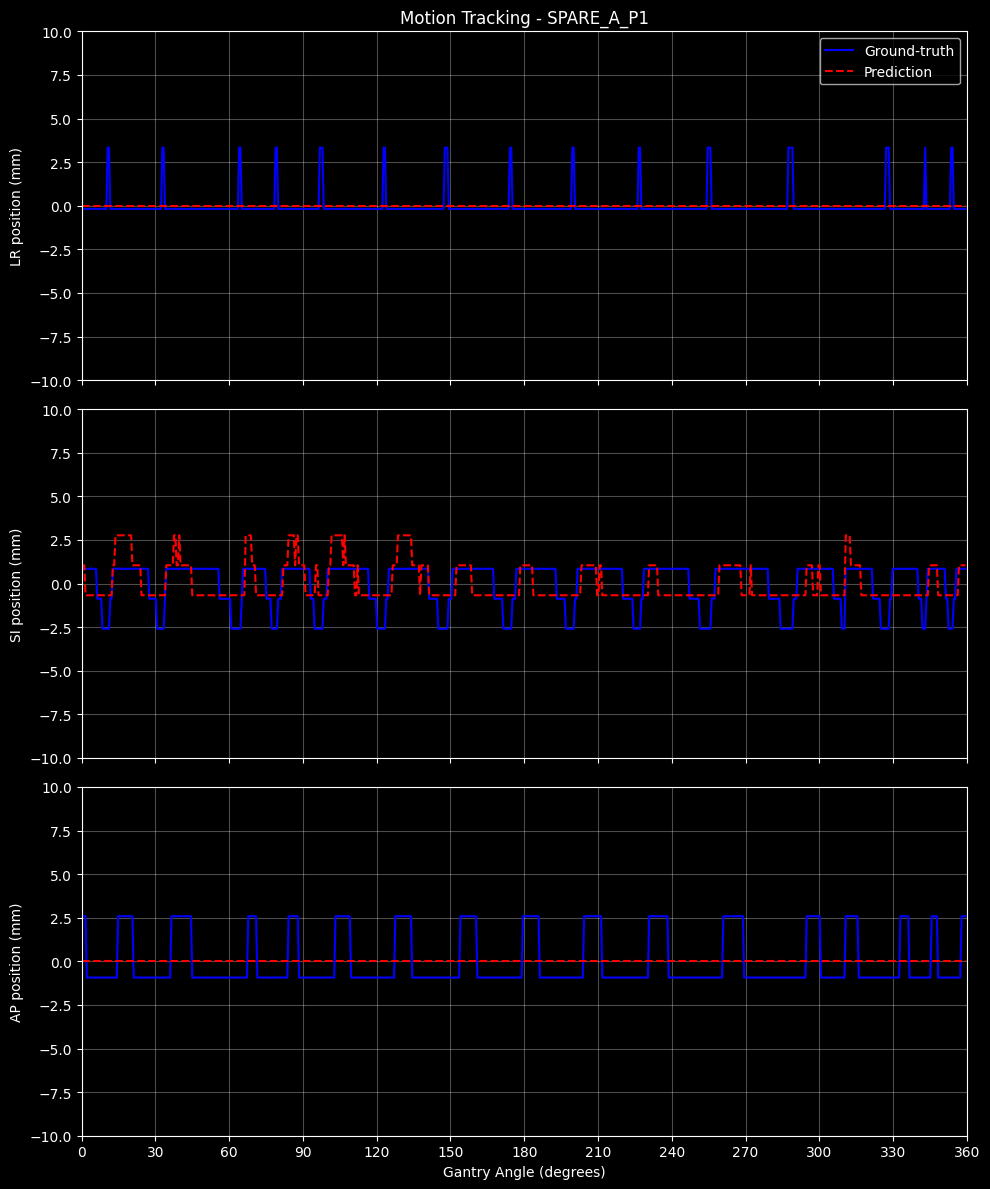

In [104]:
# 1. Print Results
# Calculate 3D Euclidean distance between Ground-Truth and Predicted centroids
dx = np.asarray(tar_lr) - np.asarray(pred_lr)
dy = np.asarray(tar_si) - np.asarray(pred_si)
dz = np.asarray(tar_ap) - np.asarray(pred_ap)
error_3d = np.sqrt(dx**2 + dy**2 + dz**2)

print('--- Global Metrics ---')
# Check if test_dice has content before printing to avoid mean of empty slice errors
if test_dice:
    print('[Target PTV Dice: %.2f ± %.2f]' % (np.mean(test_dice), np.std(test_dice)))

print('[3D Error (mm): %.1f ± %.1f | Jacobian detJ: %.0E]' % (np.mean(error_3d), np.std(error_3d), np.mean(test_detJ)))

# Consolidated OAR Print (Lung Only)
if lung_dice:
    print('[Lung ITV DSC: %.2f ± %.2f]' % (np.mean(lung_dice), np.std(lung_dice)))

print('[SSIM: %.2f ± %.2f | PSNR: %.1f ± %.1f]' % (np.mean(test_ssim), np.std(test_ssim), np.mean(test_psnr), np.std(test_psnr)))

# 2. Plot Centroid Traces
# Zero-center the traces for better comparison of motion amplitude
def prepare_trace(trace, angles):
    trace = np.asarray(trace)
    trace = trace - np.mean(trace)
    return [t for _, t in sorted(zip(angles, trace))]

tar_lr_plot = prepare_trace(tar_lr, test_angles)
tar_si_plot = prepare_trace(tar_si, test_angles)
tar_ap_plot = prepare_trace(tar_ap, test_angles)

pred_lr_plot = prepare_trace(pred_lr, test_angles)
pred_si_plot = prepare_trace(pred_si, test_angles)
pred_ap_plot = prepare_trace(pred_ap, test_angles)

sorted_angles = sorted(test_angles)

# Plotting
f, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
labels = ['LR position (mm)', 'SI position (mm)', 'AP position (mm)']
data_tar = [tar_lr_plot, tar_si_plot, tar_ap_plot]
data_pred = [pred_lr_plot, pred_si_plot, pred_ap_plot]

for idx, ax in enumerate(axes):
    ax.plot(sorted_angles, data_tar[idx], label='Ground-truth', color='blue')
    ax.plot(sorted_angles, data_pred[idx], label='Prediction', color='red', linestyle='--')
    ax.set_ylabel(labels[idx])
    ax.set_ylim([-10, 10]) # Adjusted for typical lung motion range
    ax.set_xlim([0, 360])
    ax.set_xticks(np.arange(0, 361, 30))
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.set_title(f'Motion Tracking - {expt_file}')
        ax.legend(loc='upper right')
    if idx == 2:
        ax.set_xlabel('Gantry Angle (degrees)')



f.tight_layout()
plt.savefig(f'{plot_dir}/{expt_file}_trace.png')
plt.show()

# Visualising Model Inference

Loaded weights: /home/abhishek/PycharmProjects/Voxelmap/SPARE_A_P1_weights/SPARE_A_P1_best.pth
Mask shape: (128, 128, 128)
predict_flow: (1, 3, 128, 128, 128)
predict_flow_filtered: (1, 3, 128, 128, 128)


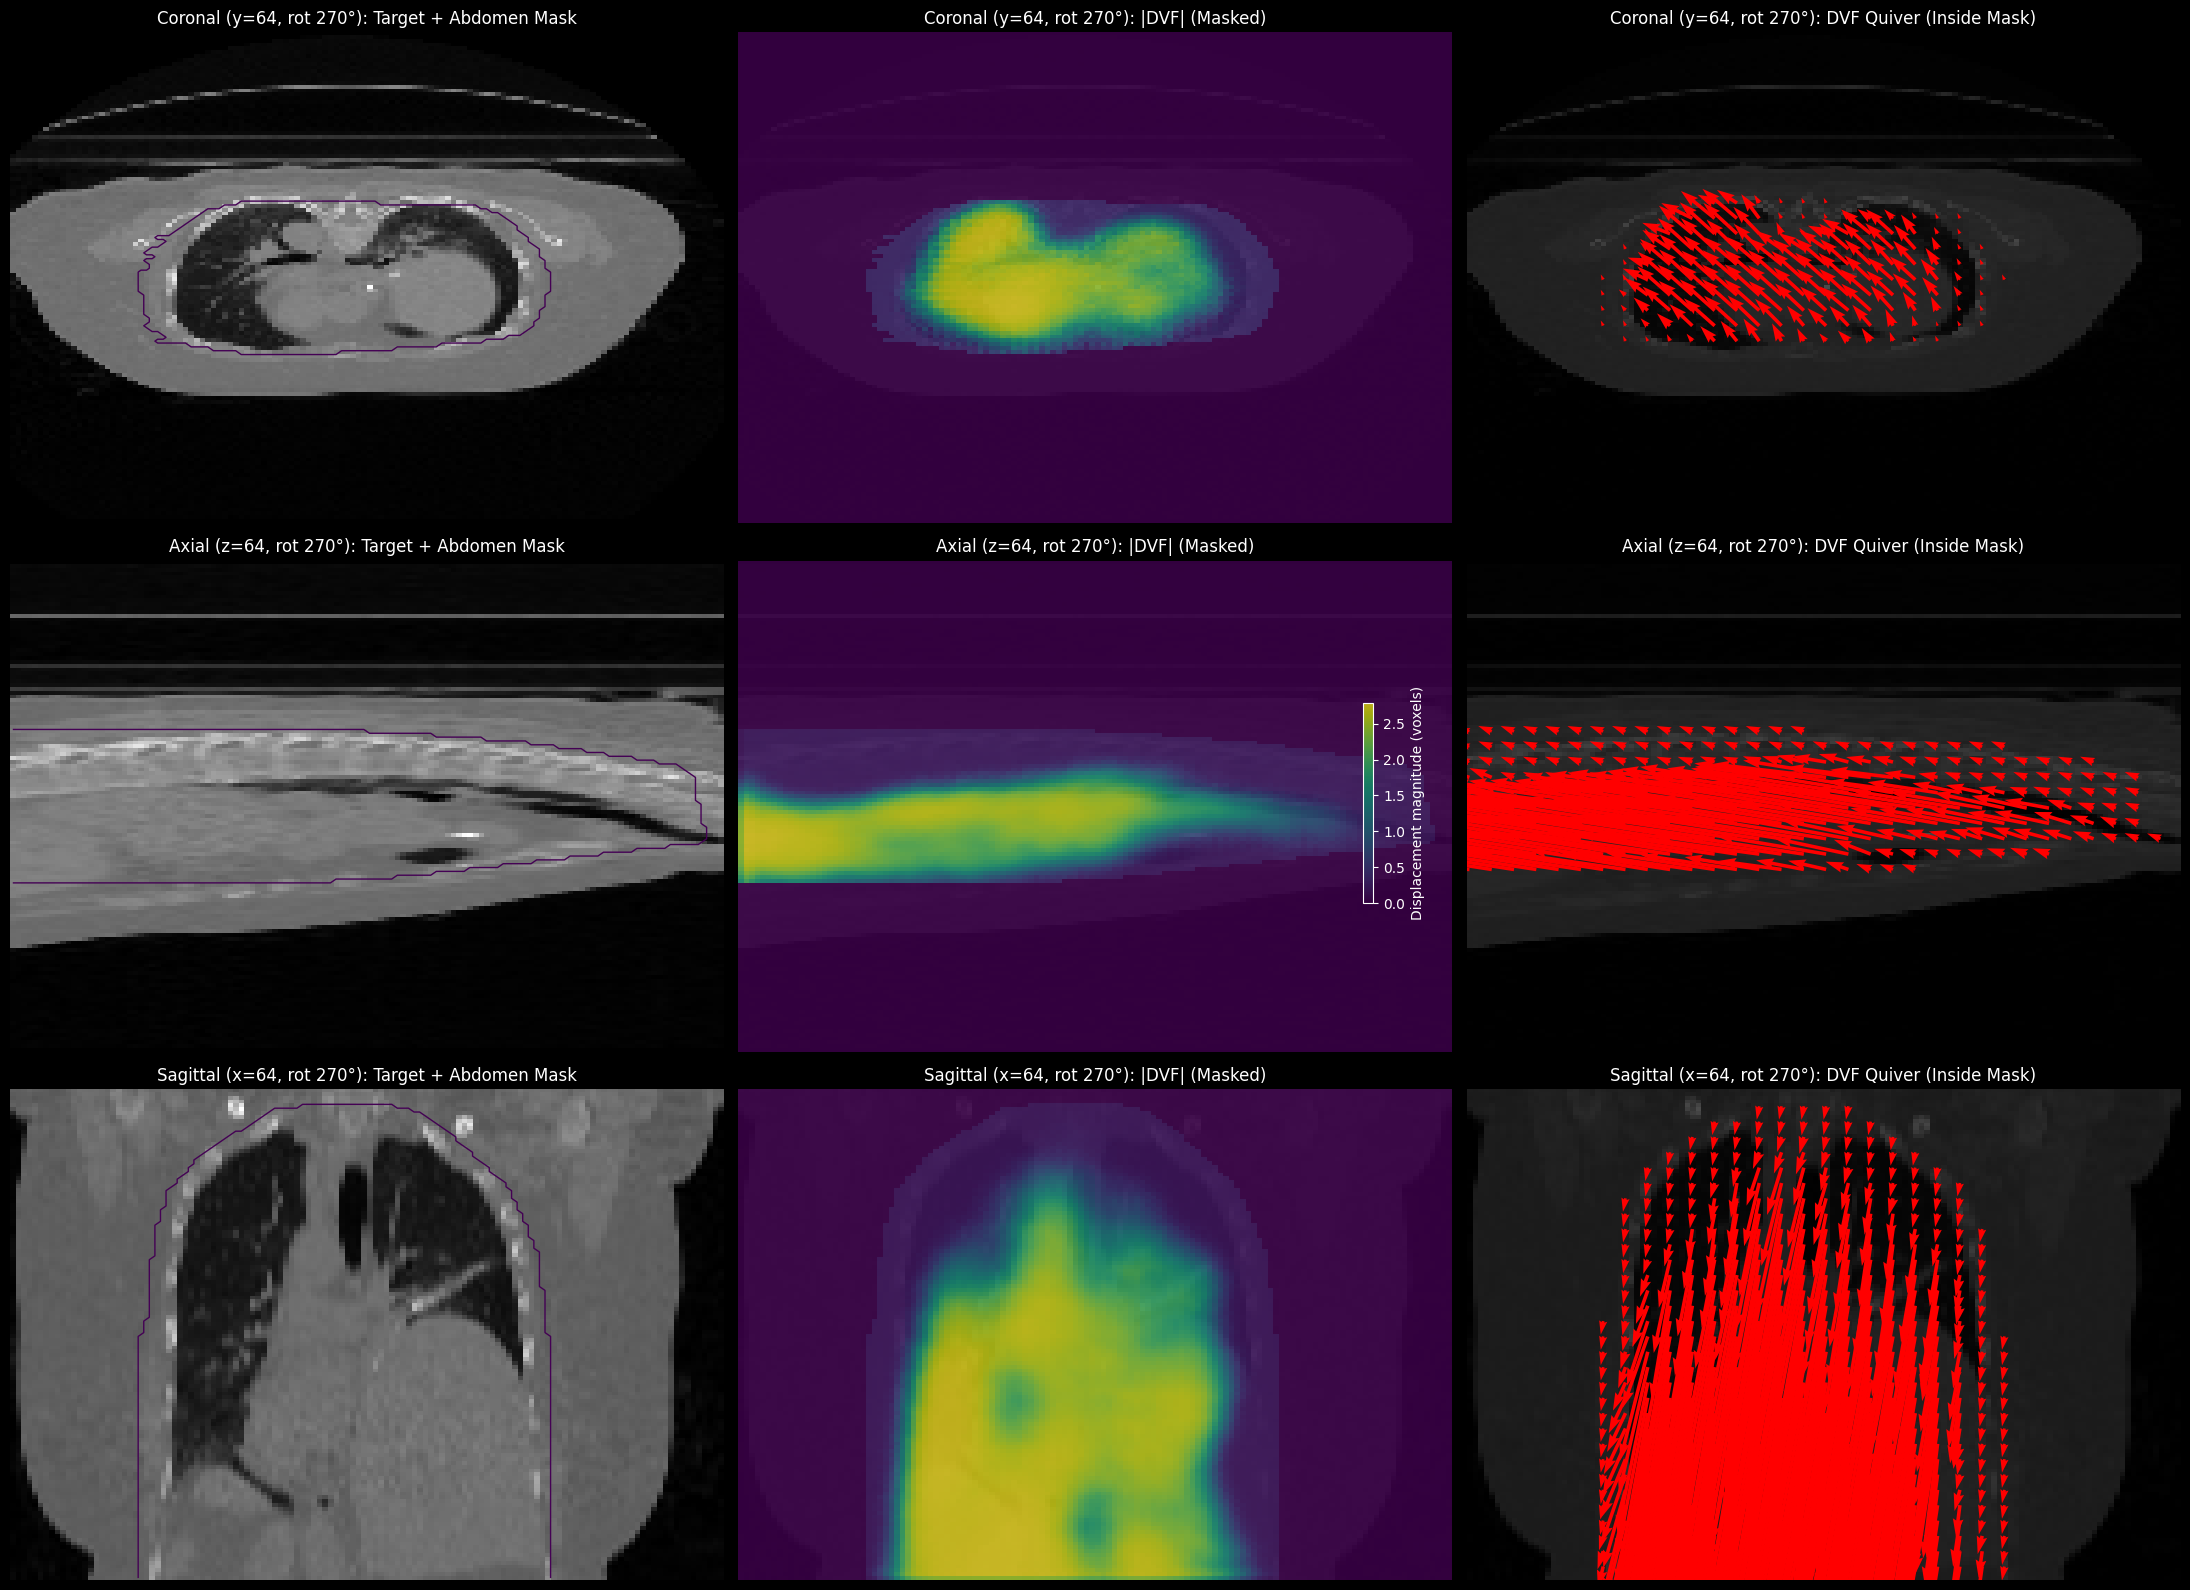

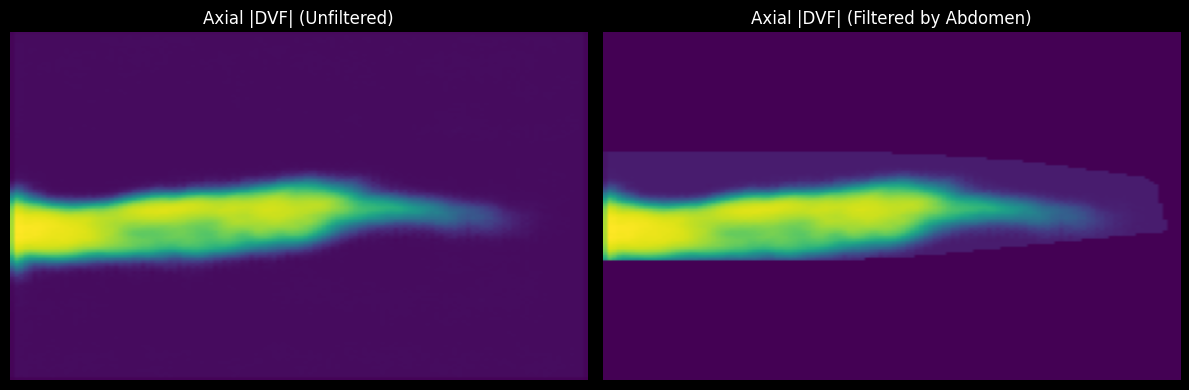

In [114]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from utilities import network_a, spatialTransform

# Config (edit these)

im_dir = "/srv/shared/SPARE/MC_V_P1_SC_02"   # dataset root (contains sub_Abdomen_mha.npy)
im_size = 128
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

WEIGHTS_PATH = "/home/abhishek/PycharmProjects/Voxelmap/SPARE_A_P1_weights/SPARE_A_P1_best.pth" # Add Your Weight Path

# DVF mask utilities
def _squeeze_leading_ones(arr: np.ndarray) -> np.ndarray:
    while arr.ndim > 0 and arr.shape[0] == 1:
        arr = arr[0]
    return arr

def load_mask_as_bool(mask_path: str, thr: float = 0.5) -> np.ndarray:
    m = np.load(mask_path)
    m = np.asarray(m)
    m = _squeeze_leading_ones(m)
    if m.ndim == 4 and m.shape[0] == 1:
        m = m[0]
    if m.ndim != 3:
        raise ValueError(f"Mask must be 3D after squeeze. Got shape {m.shape}")
    m = m.astype(np.float32, copy=False)
    return (m > thr)

def filter_dvf_with_mask(dvf, mask_bool: np.ndarray):
    """
    dvf: torch.Tensor (B,3,D,H,W) or (3,D,H,W) OR numpy array (3,D,H,W) or (D,H,W,3)
    mask_bool: numpy bool array (D,H,W)
    returns: filtered dvf, same type and same shape as input
    """
    if torch.is_tensor(dvf):
        mask_t = torch.from_numpy(mask_bool).to(dvf.device)
        if dvf.ndim == 5:
            return dvf * mask_t[None, None, ...].float()   # (1,1,D,H,W)
        if dvf.ndim == 4:
            return dvf * mask_t[None, ...].float()         # (1,D,H,W)
        raise ValueError(f"Unexpected torch dvf shape: {tuple(dvf.shape)}")

    dvf_n = np.asarray(dvf, dtype=np.float32)
    if dvf_n.ndim == 4 and dvf_n.shape[0] == 3:
        return dvf_n * mask_bool[None, ...]
    if dvf_n.ndim == 4 and dvf_n.shape[-1] == 3:
        return dvf_n * mask_bool[..., None]
    raise ValueError(f"Unexpected numpy dvf shape: {dvf_n.shape}")

# Model + transformer

model = network_a.model(im_size, int_steps=10).to(device)
transformer = spatialTransform.Network([im_size, im_size, im_size]).to(device)
transformer.eval()

if not os.path.isfile(WEIGHTS_PATH):
    raise FileNotFoundError(f"Weight file not found: {WEIGHTS_PATH}")

ckpt = torch.load(WEIGHTS_PATH, map_location=device)
state_dict = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt
if any(k.startswith("module.") for k in state_dict.keys()):
    state_dict = {k.replace("module.", "", 1): v for k, v in state_dict.items()}

missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Loaded weights:", WEIGHTS_PATH)
if missing:
    print("Missing keys:", missing)
if unexpected:
    print("Unexpected keys:", unexpected)

model.eval()


# Load abdomen mask once

mask_path = os.path.join(im_dir, "sub_Abdomen_mha.npy")
abdomen_mask = load_mask_as_bool(mask_path, thr=0.5)  # (D,H,W) bool
print("Mask shape:", abdomen_mask.shape)


# Get one batch + forward

data = next(iter(testloader))  # assumes testloader exists

source_proj = data["source_projections"].to(device)
target_proj = data["target_projections"].to(device)
source_vol  = data["source_volumes"].to(device)
target_vol  = data["target_volumes"].to(device)
source_ptv  = data["source_ptv"].to(device)

with torch.no_grad():

    _, predict_flow = model(source_proj, target_proj, source_ptv)

print("predict_flow:", tuple(predict_flow.shape))



predict_flow_filtered = filter_dvf_with_mask(predict_flow, abdomen_mask)
print("predict_flow_filtered:", tuple(predict_flow_filtered.shape))

with torch.no_grad():
    predict_vol_filtered = transformer(source_vol, predict_flow_filtered)


# # -----------------------------
# # Optional: verify masking
# # -----------------------------
# with torch.no_grad():
#     mask_t = torch.from_numpy(abdomen_mask).to(device)[None, None, ...].float()
#     outside = (mask_t == 0)
#     inside  = (mask_t == 1)
#
#     mag_before = torch.sqrt((predict_flow ** 2).sum(dim=1, keepdim=True))
#     mag_after  = torch.sqrt((predict_flow_filtered ** 2).sum(dim=1, keepdim=True))
#
#     print(f"Outside mean magnitude: before={mag_before[outside].mean().item():.6f}, "
#           f"after={mag_after[outside].mean().item():.6f}")
#     print(f"Inside  mean magnitude: before={mag_before[inside].mean().item():.6f}, "
#           f"after={mag_after[inside].mean().item():.6f}")
#     print(f"Max |flow| outside after: {mag_after[outside].max().item():.6f}")
#

# -----------------------------
# Plot helpers
# -----------------------------
def rot2d(a, k):
    return np.rot90(a, k=k)

def rotate_vectors(u, v, k):
    k = k % 4
    if k == 1:
        return -v, u
    if k == 2:
        return -u, -v
    if k == 3:
        return v, -u
    return u, v

def plot_plane_row(ax_row, tar2d, mag2d, u2d, v2d, mask2d, title_prefix, k_rot=3, step=4):
    tar_r  = rot2d(tar2d, k_rot)
    mag_r  = rot2d(mag2d, k_rot)
    u_r    = rot2d(u2d, k_rot)
    v_r    = rot2d(v2d, k_rot)
    mask_r = rot2d(mask2d.astype(np.float32), k_rot)

    u_rr, v_rr = rotate_vectors(u_r, v_r, k_rot)

    # 1) Target + mask contour
    ax_row[0].imshow(tar_r, cmap="gray", alpha=1.0, aspect="auto")
    ax_row[0].contour(mask_r, levels=[0.5], linewidths=1.0)
    ax_row[0].set_title(f"{title_prefix}: Target + Abdomen Mask")
    ax_row[0].axis("off")

    # 2) Magnitude heatmap
    ax_row[1].imshow(tar_r, cmap="gray", alpha=0.35, aspect="auto")
    hm = ax_row[1].imshow(mag_r, alpha=0.75, aspect="auto")
    ax_row[1].set_title(f"{title_prefix}: |DVF| (Masked)")
    ax_row[1].axis("off")

    # 3) Quiver (RED arrows)
    H, W = tar_r.shape
    Y, X = np.mgrid[0:H:step, 0:W:step]

    u_s = u_rr[::step, ::step]
    v_s = v_rr[::step, ::step]
    m_s = (mask_r[::step, ::step] > 0.5)

    ax_row[2].imshow(tar_r, cmap="gray", alpha=0.3, aspect="auto")
    ax_row[2].quiver(
        X[m_s], Y[m_s],
        u_s[m_s], -v_s[m_s],
        color="red",            # RED arrows
        scale=10,
        width=0.005
    )
    ax_row[2].set_title(f"{title_prefix}: DVF Quiver (Inside Mask)")
    ax_row[2].axis("off")

    return hm


# -----------------------------
# Prepare slices and fields
# -----------------------------
# Volumes: (B, C, D, H, W)
D = source_vol.shape[2]
H = source_vol.shape[3]
W = source_vol.shape[4]

z_idx = D // 2
y_idx = H // 2
x_idx = W // 2

tar_np = target_vol[0, 0].detach().cpu().numpy()                 # (D,H,W)
flow_f = predict_flow_filtered[0].detach().cpu().numpy()         # (3,D,H,W)
mask   = abdomen_mask.astype(bool)                               # (D,H,W)

# Coronal (y fixed): (z,x) u=dx v=dz
tar_cor  = tar_np[:, y_idx, :]
mask_cor = mask[:, y_idx, :]
u_cor    = flow_f[0, :, y_idx, :]
v_cor    = flow_f[2, :, y_idx, :]
mag_cor  = np.sqrt(u_cor**2 + v_cor**2)

# Axial (z fixed): (y,x) u=dx v=dy
tar_ax   = tar_np[z_idx, :, :]
mask_ax  = mask[z_idx, :, :]
u_ax     = flow_f[0, z_idx, :, :]
v_ax     = flow_f[1, z_idx, :, :]
mag_ax   = np.sqrt(u_ax**2 + v_ax**2)

# Sagittal (x fixed): (z,y) u=dy v=dz
tar_sag  = tar_np[:, :, x_idx]
mask_sag = mask[:, :, x_idx]
u_sag    = flow_f[1, :, :, x_idx]
v_sag    = flow_f[2, :, :, x_idx]
mag_sag  = np.sqrt(u_sag**2 + v_sag**2)


# -----------------------------
# Plot 3x3 grid
# -----------------------------
k_rot = 3
step = 4

fig, axes = plt.subplots(3, 3, figsize=(22, 16))

hm1 = plot_plane_row(
    axes[0], tar_cor, mag_cor, u_cor, v_cor, mask_cor,
    title_prefix=f"Coronal (y={y_idx}, rot {k_rot*90}°)", k_rot=k_rot, step=step
)
hm2 = plot_plane_row(
    axes[1], tar_ax, mag_ax, u_ax, v_ax, mask_ax,
    title_prefix=f"Axial (z={z_idx}, rot {k_rot*90}°)", k_rot=k_rot, step=step
)
hm3 = plot_plane_row(
    axes[2], tar_sag, mag_sag, u_sag, v_sag, mask_sag,
    title_prefix=f"Sagittal (x={x_idx}, rot {k_rot*90}°)", k_rot=k_rot, step=step
)

cbar = fig.colorbar(hm3, ax=axes[:, 1], fraction=0.02, pad=0.02)
cbar.set_label("Displacement magnitude (voxels)")

plt.tight_layout()
plt.show()


# -----------------------------
# Optional: compare unfiltered vs filtered magnitude on axial plane
# -----------------------------
flow_u = predict_flow[0].detach().cpu().numpy()
u0 = flow_u[0, z_idx, :, :]
v0 = flow_u[1, z_idx, :, :]
mag_unf_ax = np.sqrt(u0**2 + v0**2)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(rot2d(mag_unf_ax, k_rot), aspect="auto")
plt.title("Axial |DVF| (Unfiltered)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rot2d(mag_ax, k_rot), aspect="auto")
plt.title("Axial |DVF| (Filtered by Abdomen)")
plt.axis("off")

plt.tight_layout()
plt.show()
